In [27]:
import os
import json
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from tqdm import tqdm
from torchvision import transforms as T
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [28]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transform=None):
        self.root = root
        self.transform = transform  # 변형을 클래스 외부에서 정의하고 인자로 전달받습니다.

        with open(annotation) as f:
            self.data = json.load(f)
        self.images = self.data['images']
        self.annotations = self.data['annotations']
        self.img_to_anns = {img['id']: [] for img in self.images}
        for ann in self.annotations:
            self.img_to_anns[ann['image_id']].append(ann)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")
        anns = self.img_to_anns[img_info['id']]
        boxes = [ann['bbox'] for ann in anns]
        boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)
        boxes[:, 2:] += boxes[:, :2]
        labels = torch.as_tensor([ann['category_id'] for ann in anns], dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([img_info['id']])}

        if self.transform:
            img = self.transform(img)
        return img, target

    def __len__(self):
        return len(self.images)

In [29]:
class_id_to_name = {
    0: "background",  # 배경 클래스 추가
    1: ".",
    2: "0",
    3: "1",
    4: "2",
    5: "3",
    6: "4",
    7: "5",
    8: "6",
    9: "7",
    10: "8",
    11: "9",
    12: ".",
}


In [30]:
transform = T.Compose([
    T.ToTensor(),  # PIL 이미지를 텐서로 변환
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 이미지 정규화
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 명암 조절
])

In [31]:
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


In [32]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    loss_accum = 0.0
    for images, targets in tqdm(data_loader, desc=f"Epoch {epoch} Training"):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        loss_accum += losses.item()
    return loss_accum / len(data_loader)



def evaluate(model, data_loader, device, annotation_file):
    model.eval()
    coco_gt = COCO(annotation_file)  # COCO 객체를 파일 경로를 사용하여 초기화
    coco_dt = []  # 모델 예측 결과를 저장할 리스트

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating"):
            images = list(img.to(device) for img in images)
            outputs = model(images)

            for i, output in enumerate(outputs):
                boxes = output['boxes'].cpu().numpy()
                labels = output['labels'].cpu().numpy()
                scores = output['scores'].cpu().numpy()

                image_id = targets[i]["image_id"].item()

                for j in range(len(boxes)):
                    # NumPy 데이터 타입을 Python의 네이티브 타입으로 변환
                    box = boxes[j].tolist()  # NumPy array를 리스트로 변환
                    label = int(labels[j])  # NumPy int64를 Python int로 변환
                    score = float(scores[j])  # 이미 float이지만 명시적으로 변환
                    coco_dt.append({
                        'image_id': image_id,
                        'category_id': label,
                        'bbox': [box[0], box[1], box[2] - box[0], box[3] - box[1]],  # x, y, width, height
                        'score': score
                    })

    # COCO 결과를 임시 JSON 파일로 저장
    temp_file_name = "temp_coco_dt.json"
    with open(temp_file_name, "w") as f:
        json.dump(coco_dt, f)

    coco_dt_loaded = coco_gt.loadRes(temp_file_name)  # 임시 JSON 파일로부터 COCO 객체 생성

    coco_eval = COCOeval(coco_gt, coco_dt_loaded, "bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    os.remove(temp_file_name)  # 임시 파일 삭제

    # 평가 지표 중 하나인 mAP 반환
    return coco_eval.stats[0]


In [33]:
# 데이터셋 경로와 파라미터 설정
train_dataset = CustomDataset(root='/content/drive/MyDrive/시현이/train', annotation='/content/drive/MyDrive/시현이/train/_annotations.coco.json',transform=transform)
valid_dataset = CustomDataset(root='/content/drive/MyDrive/시현이/valid', annotation='/content/drive/MyDrive/시현이/valid/_annotations.coco.json', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [34]:
train_dataset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 {'boxes': tensor([[  0.0000, 158.0000, 176.2990, 554.0470],
          [127.0000, 124.0000, 336.4260, 530.1640],
          [286.0000,  97.0000, 503.1940, 493.2100],
          [448.0000,  62.

In [35]:
def show_images(images, targets, class_id_to_name, num_images=2):
    fig, axs = plt.subplots(1, num_images, figsize=(20, 10))
    for i in range(num_images):
        img = images[i].permute(1, 2, 0)  # C x H x W to H x W x C
        img = img.numpy()
        target = targets[i]
        boxes = target['boxes'].cpu().numpy().astype(int)
        labels = target['labels'].cpu().numpy()

        axs[i].imshow(img)
        box_labels = []  # 박스의 x 좌표와 레이블을 저장할 리스트
        for box, label in zip(boxes, labels):
            rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
            axs[i].add_patch(rect)
            class_name = class_id_to_name.get(label, 'Unknown')
            axs[i].text(box[0], box[1], class_name, color='blue', fontsize=30)
            box_labels.append((box[0], class_name))  # 박스의 x 좌표와 레이블 저장

        axs[i].axis('off')

        # 박스의 x 좌표를 기준으로 정렬
        box_labels.sort(key=lambda x: x[0])

        # 이미지 ID와 정렬된 레이블을 출력
        print(f"Image ID: {targets[i]['image_id'].item()}, Labels: {' '.join([label for _, label in box_labels])}")

    plt.show()

Image ID: 383, Labels: 4 3 0 1
Image ID: 1951, Labels: 2 1 1 0 . 0


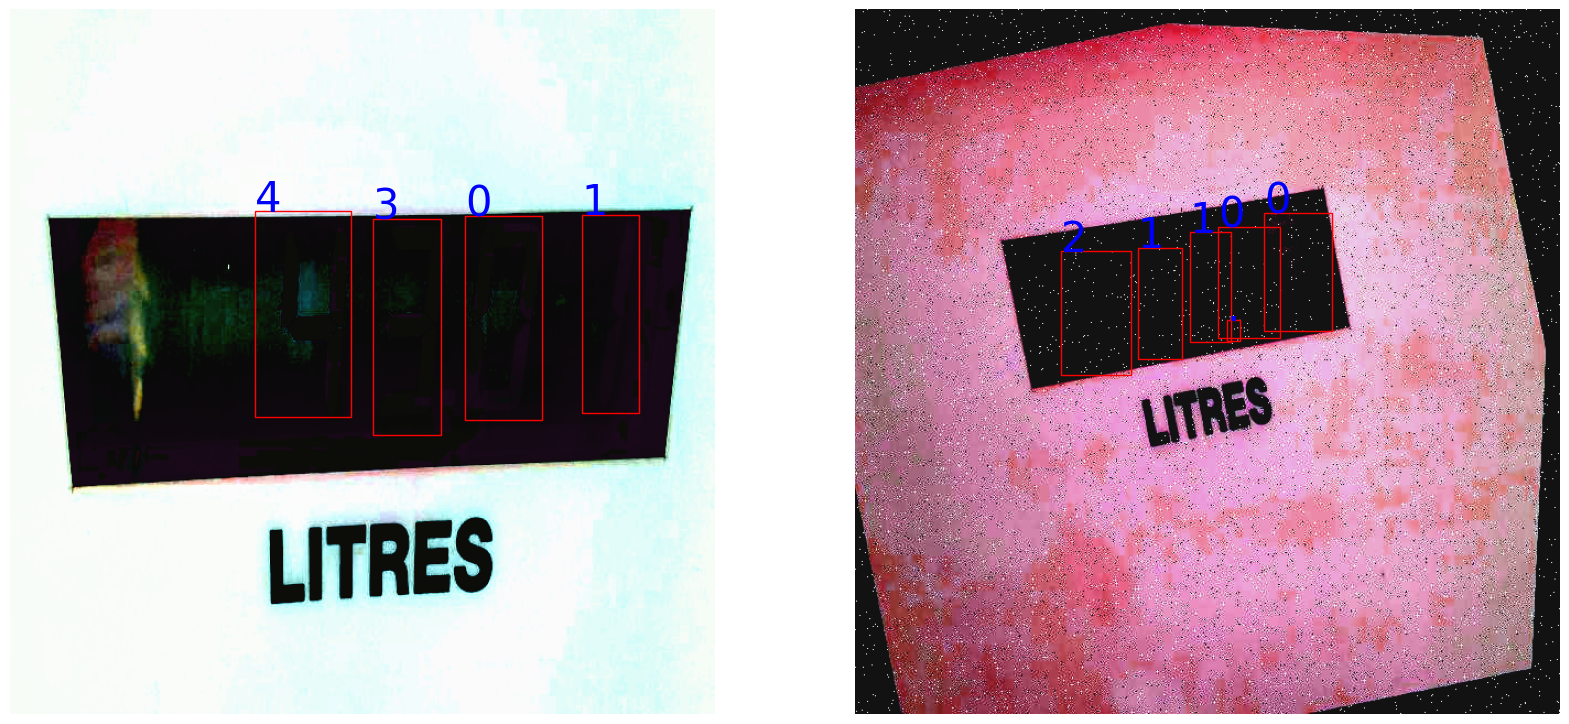

In [36]:
# DataLoader에서 데이터 배치를 가져옵니다.
images, targets = next(iter(train_loader))

# 시각화 함수를 호출합니다.
show_images(images, targets, class_id_to_name, num_images=min(2, len(images)))

In [37]:
# 모델과 옵티마이저 설정
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 12
model = get_model(num_classes)
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [38]:
!pip install pycocotools

In [39]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [40]:
train_annotation_file = '/content/drive/MyDrive/시현이/train/_annotations.coco.json'
valid_annotation_file = '/content/drive/MyDrive/시현이/valid/_annotations.coco.json'


In [41]:
from pycocotools.coco import COCO
cocoGt = COCO(valid_annotation_file)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [42]:
# num_epochs = 10
# best_loss = float('inf')

# # 모델 저장 경로 설정
# model_save_dir = './models'  # 모델을 저장할 디렉토리
# model_save_filename = 'best_model.pth'  # 모델 파일 이름
# model_save_path = os.path.join(model_save_dir, model_save_filename)  # 전체 모델 저장 경로

# # 모델 저장 디렉토리가 없으면 생성
# if not os.path.exists(model_save_dir):
#     os.makedirs(model_save_dir)

# for epoch in range(num_epochs):
#     train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)

#     # 유효성 검사 데이터셋 주석을 COCO 객체로 로드
#     valid_loss = evaluate(model, valid_loader, device, '/content/drive/MyDrive/시현이/valid/_annotations.coco.json')

#     print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")

#     # 최적 모델 저장
#     if valid_loss < best_loss:
#         best_loss = valid_loss
#         torch.save(model.state_dict(), model_save_path)  # 모델 저장 경로를 사용하여 모델 저장
#         print(f"Best model saved at {model_save_path} with Validation Loss: {best_loss:.4f}")

#     lr_scheduler.step()

In [43]:
num_epochs = 1
best_loss = float('inf')
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)

    # 유효성 검사 데이터셋 주석을 COCO 객체로 로드
    #cocoGt = COCO(valid_annotation_file)
    valid_loss = evaluate(model, valid_loader, device, '/content/drive/MyDrive/시현이/valid/_annotations.coco.json')

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")

    # 최적 모델 저장
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Best model saved with Validation Loss: {best_loss:.4f}")

    lr_scheduler.step()

Epoch 0 Training: 100%|██████████| 510/510 [07:03<00:00,  1.20it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Evaluating: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s]


Loading and preparing results...
DONE (t=0.30s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.81s).
Accumulating evaluation results...
DONE (t=0.53s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.166
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.356
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.130
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.190
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.206
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.359
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.366
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

In [44]:
# 테스트 데이터셋 로드
test_dataset = CustomDataset(root='/content/drive/MyDrive/시현이/test',
                             annotation='/content/drive/MyDrive/시현이/test/_annotations.coco.json',
                             transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

# 저장된 모델 로드
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
model.eval()

# 테스트 데이터셋에 대한 예측 및 평가
test_loss = evaluate(model, test_loader, device, '/content/drive/MyDrive/시현이/test/_annotations.coco.json')

print(f"Test Loss: {test_loss:.4f}")


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Evaluating: 100%|██████████| 25/25 [00:16<00:00,  1.51it/s]


Loading and preparing results...
DONE (t=0.72s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.10s).
Accumulating evaluation results...
DONE (t=0.40s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.338
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.148
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.042
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.158
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.177
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.213
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.384
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.391
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

In [45]:
# 저장된 모델 로드
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [46]:
def visualize_predictions(dataset, model, device):
    # 데이터셋의 모든 이미지에 대해 반복
    for i in range(len(dataset)):
        # 데이터셋에서 이미지와 타겟을 가져옵니다.
        img, _ = dataset[i]

        # 모델의 예측을 수행합니다.
        model.eval()
        with torch.no_grad():
            prediction = model([img.to(device)])

        # 예측 결과에서 바운딩 박스와 레이블, 점수를 추출합니다.
        boxes = prediction[0]['boxes']
        labels = prediction[0]['labels']
        scores = prediction[0]['scores']

        # PIL 이미지로 변환
        img = transforms.ToPILImage()(img.cpu())

        # 이미지와 예측된 바운딩 박스를 그립니다.
        plt.figure(figsize=(10,10))
        plt.imshow(img)
        ax = plt.gca()

        for box, label, score in zip(boxes, labels, scores):
            if score > 0.5:  # 점수가 0.5 이상인 바운딩 박스만 그립니다.
                x1, y1, x2, y2 = box.cpu().numpy()
                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(x1, y1, f'{dataset.class_id_to_name[label.item()]}: {score:.2f}',
                        bbox=dict(facecolor='yellow', alpha=0.5), fontsize=10, color='black')
        plt.axis('off')
        plt.show()

# 이미지 시각화 실행
visualize_predictions(test_dataset, model, device)

NameError: name 'transforms' is not defined